**The goal of this Jupyter Notebook is to:**

- Identify data quality issues, like missing values, duplicate data, etc.

- Formalize the steps to clean the datasets.

In [1]:
import os.path as osp
from datetime import datetime

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    BooleanType, DateType, DoubleType, IntegerType, LongType, StringType, StructField, StructType, TimestampType
)
from pyspark.sql import functions as F

import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("Sparkify ETL").getOrCreate()
spark

## Capital bikeshare trip data

![Capital bikeshare system map](./capital_bikeshare_system_map.png)

Data description can be found at https://www.capitalbikeshare.com/system-data.

**After initial exploration, it is found that the data schema has been changed since 05.2020. The new data schema is different from the schema listed on the official website. In the following, the data with different schemas with be merged.**

In [3]:
TRIP_DATA_FOLDER = "./datasets/capitalbikeshare_tripdata"
TRIP_DATA_PATHS_NEW = osp.join(TRIP_DATA_FOLDER, "new/*.csv")
TRIP_DATA_PATHS_OLD = osp.join(TRIP_DATA_FOLDER, "old/*.csv")

**Explore data in the new format.**

In [4]:
trip_data_new_schema = StructType([
    StructField('ride_id', StringType()),
    StructField('rideable_type', StringType()),
    StructField('started_at', TimestampType()),
    StructField('ended_at', TimestampType()),
    StructField('start_station_name', StringType()),
    StructField('start_station_id', StringType()),
    StructField('end_station_name', StringType()),
    StructField('end_station_id', LongType()),
    StructField('start_lat', DoubleType()),
    StructField('start_lng', DoubleType()),
    StructField('end_lat', DoubleType()),
    StructField('end_lng', DoubleType()),
    StructField("member_casual", StringType())
])

trip_data_new = spark.read.csv(TRIP_DATA_PATHS_NEW, header=True, schema=trip_data_new_schema)
trip_data_new.show(5)

trip_data_new.printSchema()

print("Total number new records: ", trip_data_new.count())

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+------------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|           end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+------------------+------------------+-------------+
|95D0E56BC37512F2|  docked_bike|2020-08-26 20:07:36|2020-08-26 20:36:16|Army Navy Dr & S ...|           31006|N Lynn St & Fairf...|         31917|  38.8637|  -77.0633|          38.89386|        -77.070862|       member|
|787142FE24DA497D|  docked_bike|2020-08-02 17:54:57|2020-08-02 18:12:36|      22nd & P ST NW|           31285| 14th & Up

**Explore data in the old format.**

In [5]:
trip_data_old_schema = StructType([
    StructField('Duration', DoubleType()),
    StructField('Start date', TimestampType()),
    StructField('End date', TimestampType()),
    StructField('Start station number', StringType()),
    StructField('Start station', StringType()),
    StructField('End station number', StringType()),
    StructField('End station', StringType()),
    StructField('Bike number', StringType()),
    StructField("Member type", StringType())
])

trip_data_old = spark.read.csv(TRIP_DATA_PATHS_OLD, header=True, schema=trip_data_old_schema)
trip_data_old.show(5)

trip_data_old.printSchema()

print("Total number of old records: ", trip_data_old.count())

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|   267.0|2018-07-01 00:00:58|2018-07-01 00:05:26|               31608|8th & Eye St SE /...|             31610|Eastern Market / ...|     W23296|     Member|
|   530.0|2018-07-01 00:01:00|2018-07-01 00:09:50|               31230|Metro Center / 12...|             31266|      11th & M St NW|     W20838|     Member|
|  3223.0|2018-07-01 00:01:07|2018-07-01 00:54:50|               31620|       5th & F St NW|             31289|Henry Bacon Dr & ...|     W22733|     Member|
|  2153.0|2018-07-01 00:01:13|2018-07-01 00:37:06|        

**Merge old and new data.**

In [6]:
station_data = trip_data_old.select(F.col("Start station number").alias("station_id"),
                                    F.col("Start station").alias("station_name")).distinct().union(
    trip_data_old.select("End station number", "End station").distinct()).union(
    trip_data_new.select("start_station_id", "start_station_name").distinct()).union(
    trip_data_new.select("end_station_id", "end_station_name").distinct()).distinct().sort("station_id", ascending=True).dropna(
    how="any", subset=["station_id"]).filter(F.col("station_id") != "00000").dropDuplicates(subset=["station_id"])

print("Total number of stations: ", station_data.count())

station_data.show(5, truncate=False)

station_data.printSchema()

Total number of stations:  637
+----------+------------------------------------------+
|station_id|station_name                              |
+----------+------------------------------------------+
|31000     |Eads St & 15th St S                       |
|31001     |18th & Eads St.                           |
|31002     |20th & Crystal Dr                         |
|31003     |Crystal Dr & 15th St S                    |
|31004     |Aurora Hills Community Ctr/18th & Hayes St|
+----------+------------------------------------------+
only showing top 5 rows

root
 |-- station_id: string (nullable = true)
 |-- station_name: string (nullable = true)



In [7]:
trip_data = trip_data_old.select(F.lit(None).alias("ride_id").cast(StringType()),
                                 F.lit(None).alias("rideable_type").cast(StringType()),
                                 F.col("Start date").alias("started_at"),
                                 F.col("End date").alias("ended_at"),
                                 F.col("Start station number").alias("start_station_id"),
                                 F.col("End station number").alias("end_station_id"),
                                 F.col("Member type").alias("member_casual")).union(
    trip_data_new.select("ride_id", "rideable_type", "started_at", "ended_at", "start_station_id", "end_station_id", "member_casual"))


# Clean up.
trip_data = trip_data.dropna(how="any", subset=["start_station_id", "end_station_id"]).filter(
    (F.col("start_station_id") != "00000") & (F.col("end_station_id") != "00000"))

# Add primary key "tid" and foreign key "start_date".
# FIXME: monotonically_increase_id() does not return a sequence!
trip_data = trip_data.withColumn("tid", F.monotonically_increasing_id()).withColumn("start_date", F.to_date(F.col("started_at")))

print("Total number of records: ", trip_data.count())

trip_data.show(5)

trip_data.printSchema()

Total number of records:  9252418
+-------+-------------+-------------------+-------------------+----------------+--------------+-------------+---+----------+
|ride_id|rideable_type|         started_at|           ended_at|start_station_id|end_station_id|member_casual|tid|start_date|
+-------+-------------+-------------------+-------------------+----------------+--------------+-------------+---+----------+
|   null|         null|2018-07-01 00:00:58|2018-07-01 00:05:26|           31608|         31610|       Member|  0|2018-07-01|
|   null|         null|2018-07-01 00:01:00|2018-07-01 00:09:50|           31230|         31266|       Member|  1|2018-07-01|
|   null|         null|2018-07-01 00:01:07|2018-07-01 00:54:50|           31620|         31289|       Member|  2|2018-07-01|
|   null|         null|2018-07-01 00:01:13|2018-07-01 00:37:06|           31258|         31208|       Casual|  3|2018-07-01|
|   null|         null|2018-07-01 00:01:13|2018-07-01 00:54:47|           31620|         31

## COVID data by states

Data description can be found at https://covidtracking.com/data/api.

In [8]:
COVID_DATA_PATH = "./datasets/covid_data/daily.json"

# Select only interested columns
covid_data = spark.read.json(COVID_DATA_PATH).select(
    "dataQualityGrade", "date", "state", "death", "deathIncrease", "hospitalizedCurrently", "hospitalizedDischarged", "hospitalizedIncrease", 
    "positive", "positiveIncrease", "recovered"
)

print("Total number records: ", covid_data.count())

# Select only data from Washington DC
covid_data = covid_data.filter(F.col("state") == "DC").drop("state")

covid_data.show(5)

covid_data.printSchema()

Total number records:  20780
+----------------+--------+-----+-------------+---------------------+----------------------+--------------------+--------+----------------+---------+
|dataQualityGrade|    date|death|deathIncrease|hospitalizedCurrently|hospitalizedDischarged|hospitalizedIncrease|positive|positiveIncrease|recovered|
+----------------+--------+-----+-------------+---------------------+----------------------+--------------------+--------+----------------+---------+
|            null|20210307| 1030|            0|                  150|                  null|                   0|   41419|             146|    29570|
|            null|20210306| 1030|            3|                  150|                  null|                   0|   41273|             151|    29470|
|            null|20210305| 1027|            3|                  160|                  null|                   0|   41122|             108|    29417|
|            null|20210304| 1024|            1|                  170|  

**Drop columns which has a single value (e.g. null), which typically means data is not available.**

In [9]:
covid_data.select("dataQualityGrade", "hospitalizedDischarged", "hospitalizedIncrease").distinct().show()
covid_data = covid_data.drop("dataQualityGrade", "hospitalizedDischarged", "hospitalizedIncrease")

covid_data.show(5)

+----------------+----------------------+--------------------+
|dataQualityGrade|hospitalizedDischarged|hospitalizedIncrease|
+----------------+----------------------+--------------------+
|            null|                  null|                   0|
+----------------+----------------------+--------------------+

+--------+-----+-------------+---------------------+--------+----------------+---------+
|    date|death|deathIncrease|hospitalizedCurrently|positive|positiveIncrease|recovered|
+--------+-----+-------------+---------------------+--------+----------------+---------+
|20210307| 1030|            0|                  150|   41419|             146|    29570|
|20210306| 1030|            3|                  150|   41273|             151|    29470|
|20210305| 1027|            3|                  160|   41122|             108|    29417|
|20210304| 1024|            1|                  170|   41014|             196|    29287|
|20210303| 1023|            4|                  177|   40818|

**Convert type of column "date" from `long` to `date`.**

In [10]:
func =  F.udf(lambda x: datetime.strptime(str(x), '%Y%m%d'), DateType())

covid_data = covid_data.withColumn("date", func(F.col("date")))
covid_data.orderBy("date").show(5)

covid_data.printSchema()

+----------+-----+-------------+---------------------+--------+----------------+---------+
|      date|death|deathIncrease|hospitalizedCurrently|positive|positiveIncrease|recovered|
+----------+-----+-------------+---------------------+--------+----------------+---------+
|2020-03-05| null|            0|                 null|       0|               0|     null|
|2020-03-06| null|            0|                 null|       0|               0|     null|
|2020-03-07| null|            0|                 null|       0|               0|     null|
|2020-03-08| null|            0|                 null|       1|               1|     null|
|2020-03-09| null|            0|                 null|       1|               0|     null|
+----------+-----+-------------+---------------------+--------+----------------+---------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- death: long (nullable = true)
 |-- deathIncrease: long (nullable = true)
 |-- hospitalizedCurrently: long (nulla

**Fill null with 0. Actually, the null values were discovered by the following visualization. It is reasonable to do it since null values only appears at the beginning of the outbreak.**

In [11]:
covid_data = covid_data.fillna(0).orderBy("date")

**Drop possible duplicated rows.**

In [12]:
print("Before dropDuplicates: ", covid_data.count())
covid_data = covid_data.dropDuplicates(["date"])
print("After dropDuplicates: ", covid_data.count())

Before dropDuplicates:  368
After dropDuplicates:  368


**Sanity check by plotting the temperature data and wind speed data.**

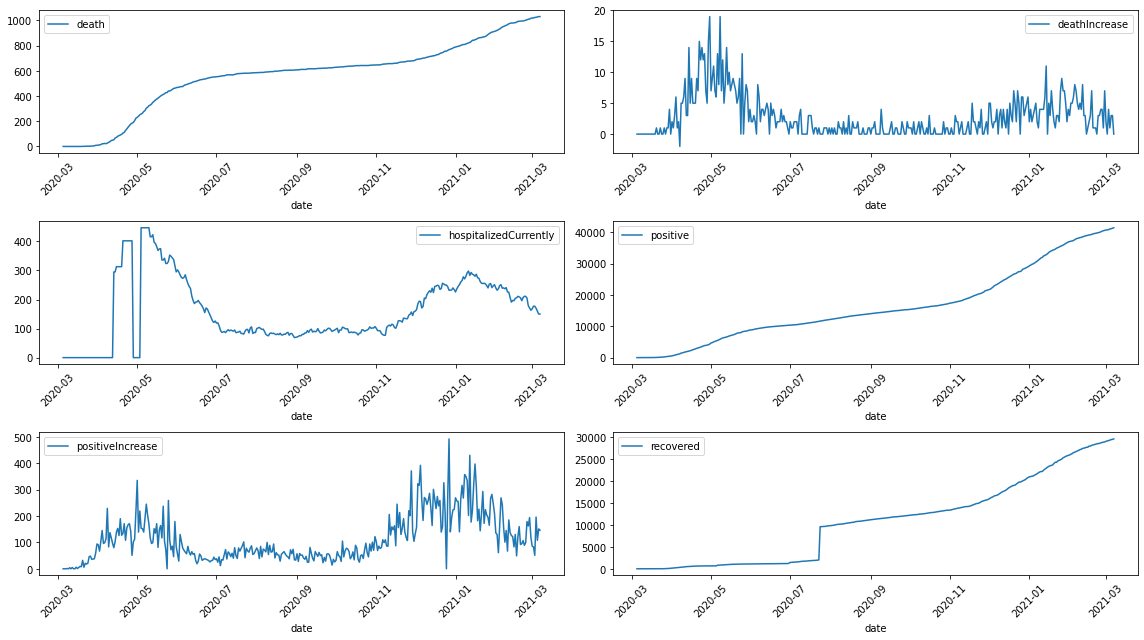

In [13]:
covid_df = covid_data.toPandas()

_, axes = plt.subplots(3, 2, figsize=(16, 9))

for col, ax in zip(list(covid_df.columns[1:]), axes.flatten()):
    covid_df.plot("date", col, ax=ax)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()

**Note: the dip in the "hospitalizedCurrently" plot and the jump in the "recovered" plot are both suspicious!**

## Weather data

- AWND: Average daily wind speed (miles per hour)
- TAVG: Average temperature (Fahrenheit)
- TMAX: Maximum temperature (Fahrenheit)
- TMIN: Minimum temperature (Fahrenheit)
- TOBS: Temperature at the time of observation (Fahrenheit)
- WDF2: Direction of fastest 2-minute wind (degrees)
- WDF5: Direction of fastest 5-second wind (degrees)
- WSF2: Fastest 2-minute wind speed (miles per hour)
- WSF5: Fastest 5-second wind speed (miles per hour)
- WDMV: 24-hour wind movement (miles)
- WT01: Fog, ice fog, or freezing fog (may include heavy fog)
- WT02: Heavy fog or heaving freezing fog (not always distinguished from fog)
- WT03: Thunder
- WT04: Ice pellets, sleet, snow pellets, or small hail
- WT05: Hail (may include small hail)
- WT06: Glaze or rime
- WT08: Smoke or haze
- WT11: High or damaging winds

In [14]:
WEATHER_DATA_PATH = "./datasets/weather_data/*_daily.csv"

weather_data_schema = StructType([
    StructField('STATION', StringType()),
    StructField('NAME', StringType()),
    StructField('DATE', DateType()),
    StructField('AWND', DoubleType()),
    StructField('TAVG', DoubleType()),
    StructField('TMAX', DoubleType()),
    StructField('TMIN', DoubleType()),
    StructField('TOBS', DoubleType()),
    StructField('WDF2', DoubleType()),
    StructField('WDF5', DoubleType()), 
    StructField('WDMV', DoubleType()), 
    StructField('WSF2', DoubleType()),
    StructField('WSF5', DoubleType()),
    StructField('WT01', StringType()),
    StructField('WT02', StringType()), 
    StructField('WT03', StringType()), 
    StructField('WT04', StringType()), 
    StructField('WT05', StringType()), 
    StructField('WT06', StringType()), 
    StructField('WT08', StringType()), 
    StructField('WT11', StringType())
])

weather_data = spark.read.csv(WEATHER_DATA_PATH, header=True, schema=weather_data_schema).drop(
    "NAME", "TOBS", "WDF2", "WDF5", "WDMV", "WSF2", "WSF5")

weather_data.show(5)

print("Total number records: ", weather_data.count())

+-----------+----------+----+----+----+----+----+----+----+----+----+----+----+----+
|    STATION|      DATE|AWND|TAVG|TMAX|TMIN|WT01|WT02|WT03|WT04|WT05|WT06|WT08|WT11|
+-----------+----------+----+----+----+----+----+----+----+----+----+----+----+----+
|US1MDMG0109|2020-01-01|null|null|null|null|null|null|null|null|null|null|null|null|
|US1MDMG0109|2020-01-02|null|null|null|null|null|null|null|null|null|null|null|null|
|US1MDMG0109|2020-01-03|null|null|null|null|null|null|null|null|null|null|null|null|
|US1MDMG0109|2020-01-04|null|null|null|null|null|null|null|null|null|null|null|null|
|US1MDMG0109|2020-01-05|null|null|null|null|null|null|null|null|null|null|null|null|
+-----------+----------+----+----+----+----+----+----+----+----+----+----+----+----+
only showing top 5 rows

Total number records:  128579


**Remove rows if any of the columns "AWND", "TAVG", "TMAX" and "TMIN" contain null. Afterwards, replace null in WT?? with 0 and cast the data type to boolean.**


In [15]:
print("Number of stations before filtering: ", weather_data.select('STATION').distinct().count())

weather_data = weather_data.filter(F.col("AWND").isNotNull()).filter(F.col("TAVG").isNotNull()).filter(F.col("TMAX").isNotNull()).filter(F.col("TMIN").isNotNull())

print("Number of stations after filtering: ", weather_data.select('STATION').distinct().count())

for i in ['01', "02", "03", "04", "05", "06", "08", "11"]:
    col_name = f"WT{i}"
    orig_col_name = f"{col_name}_orig"
    weather_data = weather_data.fillna('0', subset=[col_name]).withColumnRenamed(col_name, orig_col_name)
    weather_data = weather_data.withColumn(col_name, F.col(orig_col_name).cast(BooleanType())).drop(orig_col_name)

weather_data.show(5)

weather_data.printSchema()

print("Total number records: ", weather_data.count())

Number of stations before filtering:  177
Number of stations after filtering:  3
+-----------+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|    STATION|      DATE| AWND|TAVG|TMAX|TMIN| WT01| WT02| WT03| WT04| WT05| WT06| WT08| WT11|
+-----------+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|USW00093721|2020-01-01| 9.84|45.0|49.0|29.0|false|false|false|false|false|false|false|false|
|USW00093721|2020-01-02| 2.24|37.0|54.0|25.0|false|false|false|false|false|false|false|false|
|USW00093721|2020-01-03|  4.7|49.0|53.0|47.0| true| true|false|false|false|false|false|false|
|USW00093721|2020-01-04| 4.92|53.0|59.0|45.0| true| true|false|false|false|false|false|false|
|USW00093721|2020-01-05|12.53|42.0|45.0|30.0|false|false|false|false|false|false|false|false|
+-----------+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
only showing top 5 rows

root
 |-- STATION: string (nullable = true)
 |--

**To make my life easy, I select one of the three stations. Of course, one could use the aggregated values of the three stations, or map weather station to bike station.**

In [16]:
weather_data = weather_data.filter(F.col("STATION") == "USW00093721").drop("STATION")

print("Total number records: ", weather_data.count())

# There is no duplicated row.
assert(weather_data.select("DATE").distinct().count() == weather_data.count())

Total number records:  1205


In [17]:
weather_data.show(5)

weather_data.printSchema()

+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|      DATE| AWND|TAVG|TMAX|TMIN| WT01| WT02| WT03| WT04| WT05| WT06| WT08| WT11|
+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|2020-01-01| 9.84|45.0|49.0|29.0|false|false|false|false|false|false|false|false|
|2020-01-02| 2.24|37.0|54.0|25.0|false|false|false|false|false|false|false|false|
|2020-01-03|  4.7|49.0|53.0|47.0| true| true|false|false|false|false|false|false|
|2020-01-04| 4.92|53.0|59.0|45.0| true| true|false|false|false|false|false|false|
|2020-01-05|12.53|42.0|45.0|30.0|false|false|false|false|false|false|false|false|
+----------+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+
only showing top 5 rows

root
 |-- DATE: date (nullable = true)
 |-- AWND: double (nullable = true)
 |-- TAVG: double (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMIN: double (nullable = true)
 |-- WT01: boolean (nullable = true)
 |-- WT02: boolea

**Sanity check by plotting the temperature data and wind speed data.**

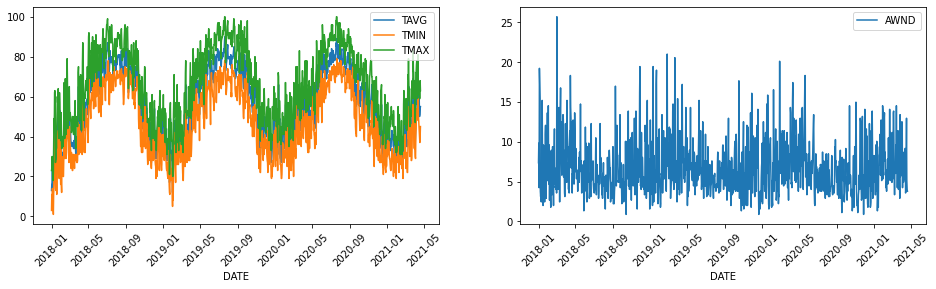

In [18]:
weather_df = weather_data.toPandas()

_, axes = plt.subplots(1, 2, figsize=(16, 4))

weather_df.plot("DATE", ["TAVG", "TMIN", "TMAX"], ax=axes[0])
weather_df.plot("DATE", "AWND", ax=axes[1])

for ax in axes:
    ax.tick_params(axis='x', labelrotation=45)